In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from tqdm import tqdm
import cv2

from model import Yolo
from loss import YoloLoss
import os

In [2]:
# pip install os

In [3]:
from PIL import Image

# Open the image file
with Image.open('sample/data/000000.png') as img:
    # Get the width and height of the image
    Image_Width, Image_Height = img.size
    print(f"Image size: {Image_Width} x {Image_Height}")


#kitti dataset의 실제크기, resize를 위해 파악

Image size: 1242 x 375


In [4]:

torch.cuda.is_available() 
print(torch.cuda.device_count())

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

1


'cuda'

### 라벨 전처리

In [5]:
# [class],[Pc = confidence score],[x], [y], [w], [h],[distance] = 0~7 c x y w h dist


In [6]:
# column_names=['class','truncated','occluded','alpha','x1','y1','x2','y2','dimensions_h','dimensions_w','dimensions_len','location_x','location_y','distance','rotation_y']
# one_hot_labeling={'Car':0, 'Van':1, 'Truck':2,'Pedestrian':3, 'Person_sitting':4, 'Cyclist':5, 'Tram':6,'Misc':7, 'DontCare':7}        #Misc and DontCare is same value


# import os

# folder_path = "dataset/training/label_2"

# #txt파일 단위로 불러옴
# for filename in tqdm(os.listdir(folder_path)):
#     temp=pd.read_csv(folder_path+'/'+filename,delimiter=' ',names=column_names)
#     temp=temp.drop(columns=['truncated','occluded','alpha','dimensions_h','dimensions_w','dimensions_len','location_x','location_y','rotation_y'])

#     #class one hot vector로 변환
#     temp['class'] = np.array(list(map(lambda x:one_hot_labeling[x],list(temp['class'])))).reshape(-1, 1)

 

#     temp

#     # 좌표 resize 416* 416
#     temp['x1'] = ((416.0/Image_Width)*temp['x1'])
#     temp['y1'] = ((416.0/Image_Height)*temp['y1'])
#     temp['x2'] = ((416.0/Image_Width)*temp['x2'])
#     temp['y2'] = ((416.0/Image_Height)*temp['y2'])

#     # x y w h 형식으로 bbox 변환 (여기서 x y는 중심좌표,)   
#     center_x=(temp['x1'] + temp['x2'])/2.0
#     center_y=(temp['y1'] + temp['y2'])/2.0
#     w=temp['x2'] - temp['x1']
#     h=temp['y2'] - temp['y1']
#     temp['x1'] = center_x
#     temp['y1'] = center_y
#     temp['x2'] = w
#     temp['y2'] = h

#     temp.rename(columns = {'x1' : 'x','y1' : 'y','x2' : 'w','y2' : 'h'}, inplace = True)

#     #txt형태로 파일 덮어쓰기 
#     temp.to_csv(folder_path+'/'+filename,sep=' ',index = False , header=None)


# # # #이후 데이터셋에서 텐서로 바꿀때 index 8에 c score 자리 만들기


In [7]:
int(416/32)


13

### custom dataset

In [8]:
class CustomDataset(torch.utils.data.Dataset):
    # S= grid cell, B= num of anchors, C = num of classes
    def __init__(self, folder_dir, img_dir, label_dir, S=13, B=5, C=8, transform=None):         
        self.img_folder=folder_dir[0]
        self.label_folder=folder_dir[1]
        self.img_path=img_dir
        self.label_path=label_dir
        
        self.S=S
        self.B=B
        self.C=C
        self.transform=transform
        
    def __len__(self):
        return len(self.img_path)
        

    def __getitem__(self, idx):
        
        #image 전처리
        
        image_filepath = self.img_folder+self.img_path[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (416, 416))
        image=image.transpose(2,0,1)
        image=torch.from_numpy(image).float().div(255.0)
        image.requires_grad=True
        #label 추가 전처리

        bboxes=np.loadtxt(self.label_folder+self.label_path[idx]).tolist()

        label_matrix = torch.zeros((self.S, self.S, self.C+6 )) # 13*13*14(class(8) + c_score x y w h distance)
        
        try:
            for bbox in bboxes:
                # print(bbox)
                class_label=int(bbox[0]) 
                x, y=bbox[1],bbox[2]
                width, height= bbox[3],bbox[4]
                distance= bbox[5]

                # x, y의 위치 grid cell 파악하기
                x_cell = int(x/32) # 0~12
                y_cell = int(y/32) # 0~12
                x_val_inCell = float((x - x_cell * 32.0)/32.0) # 0.0 ~ 1.0
                y_val_inCell = float((y - y_cell * 32.0)/32.0) # 0.0 ~ 1.0

                # w, h 를 0~1 사이의 값으로 만들기
                w = width / 416.0
                h = height / 416.0



                label_matrix[y_cell, x_cell, 8] = 1.0                                       #c_score 8 in pred
                label_matrix[y_cell, x_cell, class_label] = 1.0     #idx 0~7
                label_matrix[y_cell, x_cell, 9] = x_val_inCell                              #bbox 9~12
                label_matrix[y_cell, x_cell, 10] = y_val_inCell
                label_matrix[y_cell, x_cell, 11] = w
                label_matrix[y_cell, x_cell, 12] = h
                label_matrix[y_cell, x_cell, 13] = distance                                 #distance 13
                
                
        # single label
        except TypeError as e:
  
            bbox=bboxes
            class_label=int(bbox[0])
            x, y=bbox[1],bbox[2]
            width, height= bbox[3],bbox[4]
            distance= bbox[5]

            # x, y의 위치 grid cell 파악하기
            x_cell = int(x/32) # 0~12
            y_cell = int(y/32) # 0~12
            x_val_inCell = float((x - x_cell * 32.0)/32.0) # 0.0 ~ 1.0
            y_val_inCell = float((y - y_cell * 32.0)/32.0) # 0.0 ~ 1.0

            # w, h 를 0~1 사이의 값으로 만들기
            w = width / 416.0
            h = height / 416.0

            label_matrix[y_cell, x_cell, 8] = 1.0                                       #c_score 8
            label_matrix[y_cell, x_cell, class_label] = 1.0     #idx 0~7
            label_matrix[y_cell, x_cell, 9] = x_val_inCell                              #bbox 9~12
            label_matrix[y_cell, x_cell, 10] = y_val_inCell
            label_matrix[y_cell, x_cell, 11] = w
            label_matrix[y_cell, x_cell, 12] = h
            label_matrix[y_cell, x_cell, 13] = distance                                 #distance 13
         
        return image.to(device), label_matrix.to(device)

In [9]:
img_label_folder_path=['dataset/data_object_image_2/training/image_2/','dataset/training/label_2/']
img_path=os.listdir('dataset/data_object_image_2/training/image_2/')
label_path=os.listdir('dataset/training/label_2/')
dset=CustomDataset(img_label_folder_path,img_path,label_path)

In [10]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dset, batch_size=4, shuffle=True)

In [11]:

# for batch_idx, samples in tqdm(enumerate(dataloader)):
#     _,l=samples
#     # print(l[-1][0])
#     break

torch.Size([4, 13, 13, 14])
torch.Size([416, 416, 3])


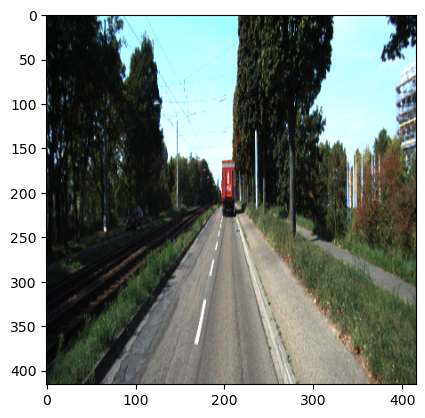

In [12]:
import matplotlib.pyplot as plt

for batch_idx, (inputs, labels) in enumerate(dataloader):
    print(labels.shape)

    inputs= inputs[0]
    inputs.to(device)
    inputs = inputs.permute(1,2,0)
    print(inputs.shape)
    plt.figure()
    plt.imshow(inputs.cpu().detach().numpy())
    plt.show()
    break

### model training

In [13]:
model = Yolo(8).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001) 
criterion=YoloLoss()


In [14]:
# criterion(prediction, y_train)

In [15]:
loss_lst=[]
lt = len(dset)

In [16]:
nb_epochs = 10
for epoch in range(nb_epochs + 1):
  model.train()
  total_loss=0
  for batch_idx, samples in (enumerate(dataloader)):
    # print(batch_idx)
    # print(samples)
    x_train, y_train = samples
    # H(x) 계산
    prediction = model(x_train)
    # cost 계산
    # cost,localization_loss,confidence_loss,classification_loss,distance_regression_loss = criterion(prediction, y_train)
    
    cost = criterion(prediction, y_train)
    
    # # cost로 H(x) 계산
    optimizer.zero_grad()
    cost.mean().backward()
    
    optimizer.step()
  
    # print(cost)
    print('Epoch {:4d}/{} Batch {}/{} total loss: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),
        cost.mean()
        ))
    total_loss+=cost.mean()
  loss_lst.append(total_loss/lt)
  

del loss
Epoch    0/10 Batch 1/1871 total loss: 89557.703125
del loss
Epoch    0/10 Batch 2/1871 total loss: 48146.250000
del loss
Epoch    0/10 Batch 3/1871 total loss: 46764.687500
del loss
Epoch    0/10 Batch 4/1871 total loss: 28496.136719
del loss
Epoch    0/10 Batch 5/1871 total loss: 117141.351562
del loss
Epoch    0/10 Batch 6/1871 total loss: 32114.212891
del loss
Epoch    0/10 Batch 7/1871 total loss: 90765.820312
del loss
Epoch    0/10 Batch 8/1871 total loss: 103051.453125
del loss
Epoch    0/10 Batch 9/1871 total loss: 45257.699219
del loss
Epoch    0/10 Batch 10/1871 total loss: 46482.058594
del loss
Epoch    0/10 Batch 11/1871 total loss: 74586.460938
del loss
Epoch    0/10 Batch 12/1871 total loss: 101090.851562
del loss
Epoch    0/10 Batch 13/1871 total loss: 69163.125000
del loss
Epoch    0/10 Batch 14/1871 total loss: 19969.367188
del loss
Epoch    0/10 Batch 15/1871 total loss: 108116.640625
del loss
Epoch    0/10 Batch 16/1871 total loss: 96691.929688
del loss
Epoc

KeyboardInterrupt: 

In [ ]:
# torch.save(model.state_dict(), 'saved_model_5epoch')

In [ ]:
print(loss_lst)